### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가


#### 라이브러리 및 데이터 세트 로딩, 이전 application 

In [1]:
import numpy as np
import pandas as pd
import gc, time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [2]:
app_train = pd.read_csv('../rawdata/application_train.csv')
app_test = pd.read_csv('../rawdata/application_test.csv')

In [3]:
def get_apps_dataset():
    app_train = pd.read_csv('../rawdata/application_train.csv')
    app_test = pd.read_csv('../rawdata/application_test.csv')

    apps = pd.concat([app_train, app_test])

    return apps

In [4]:
apps = get_apps_dataset()

#### 이전 application 데이터의 feature engineering 함수 복사

In [5]:
def get_apps_processed(apps):

    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_CREDIT']

    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['CNT_FAM_MEMBERS']

    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED'] / apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']

    return apps

#### previous 데이터 로딩

In [6]:
prev = pd.read_csv('../rawdata/previous_application.csv')
prev.shape, apps.shape

((1670214, 37), (356255, 122))

In [7]:
apps.shape

(356255, 122)

In [8]:
prev.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

#### application과 previous outer를 조인하고 누락된 집합들 확인

In [9]:
prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
prev_app_outer.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0   2030495.0      271877     Consumer loans     1730.430          17145.0   
1   1696966.0      271877     Consumer loans    68258.655        1800000.0   
2   2154916.0      271877     Consumer loans    12417.390         108400.5   
3   2802425.0      108129         Cash loans    25188.615         607500.0   
4   1536272.0      108129         Cash loans    21709.125         450000.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1   1754721.0          180000.0        1800000.0                   SATURDAY   
2    119848.5               0.0         108400.5                     SUNDAY   
3    679671.0               NaN         607500.0                   THURSDAY   
4    512370.0               NaN         450000.0                  WEDNESDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     18.0                           Y   
2                     14.0                           Y   
3                     11.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0           0.000000               0.182832   
1                     1.0           0.101325                    NaN   
2                     1.0           0.000000                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XAP              Refused   
2                       NaN                    XAP             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                    XNA             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0          -73.0  Cash through the bank                XAP             NaN   
1         -472.0  Cash through the bank                SCO             NaN   
2         -548.0  Cash through the bank                XAP             NaN   
3         -164.0                    XNA                XAP   Unaccompanied   
4         -515.0                    XNA                XAP             NaN   

  NAME_CLIENT_TYPE       NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater                    Mobile            POS               XNA   
1         Repeater  Clothing and Accessories            POS               XNA   
2              New                 Furniture            POS               XNA   
3         Repeater                       XNA           Cash            x-sell   
4         Repeater                       XNA           Cash            x-sell   

       CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0      Country-wide              35.0         Connectivity         12.0   
1  Regional / Local              55.0            Furniture         36.0   
2             Stone             196.0            Furniture         12.0   
3    Contact center              -1.0                  XNA         36.0   
4   AP+ (Cash loan)               6.0                  XNA         36.0   

  NAME_YIELD_GROUP         PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0           middle    POS mobile with interest            365243.0   
1       low_normal  POS industry with interest                 NaN   
2           middle  POS industry with interest            365243.0   
3       low_action            Cash X-Sell: low            365243.0   
4       low_normal            Cash X-Sell: low            365243.0   

   D

In [10]:
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

#### previous 컬럼과 NULL 값 조사

In [11]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

### 주요 컬럼 EDA 수행

#### SK_ID_CURR 당 평균 SK_ID_PREV 건수 구하기
- groupby로 평균 건수 구함
- boxplot으로 시각화

In [12]:
prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count().mean()

4.928964135313716

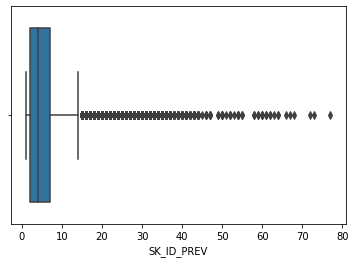

In [13]:
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count())

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교
- application_train의 TARGET값을 가져오기 위해 prev와 app_train을 inner_join후 TARGET 유형에 따라 비교
- 숫자형 컬럼명 필터링

In [14]:
app_prev = prev.merge(app_train[['SK_ID_CURR','TARGET']], on='SK_ID_CURR', how='left')

In [15]:
app_prev.shape


(1670214, 38)

In [16]:
def show_hist_by_target(df: pd.DataFrame, columns: list):
    """Returns Histogram upon target data
    Args:
        df: Pandas DataFrame
        columns: 히스토그램을 표시할 column 목록
    Returns:
        Histograms upon target data
    """
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)

    for column in columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axes[0][0])
        sns.distplot(df[cond_0][column], ax=axes[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axes[0][1], label='1', color='red')

In [17]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns  = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]

In [18]:
num_columns

['AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

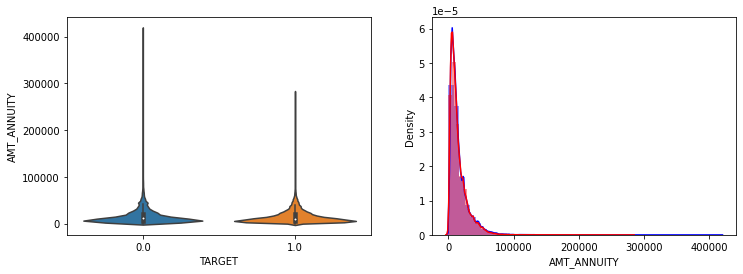

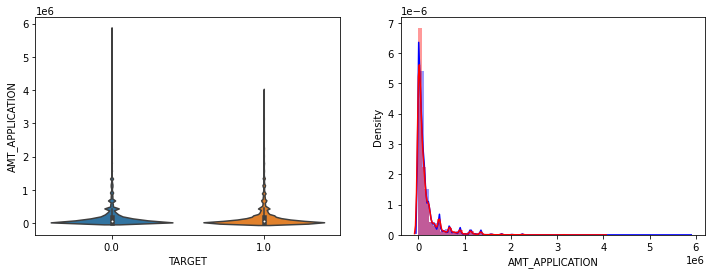

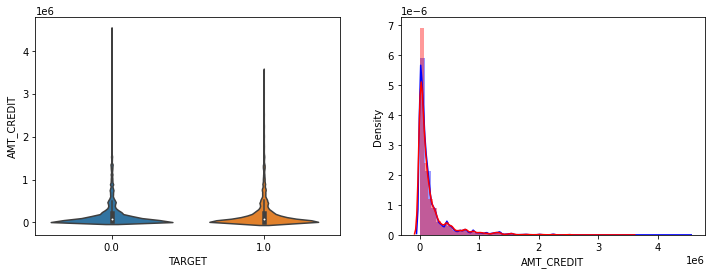

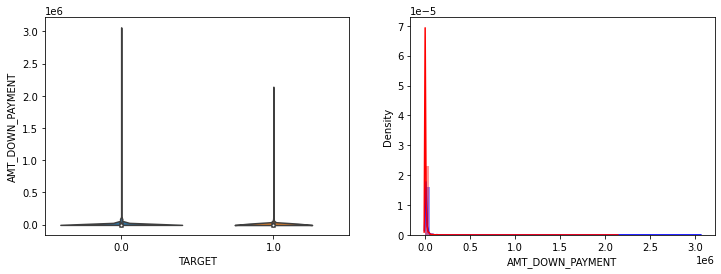

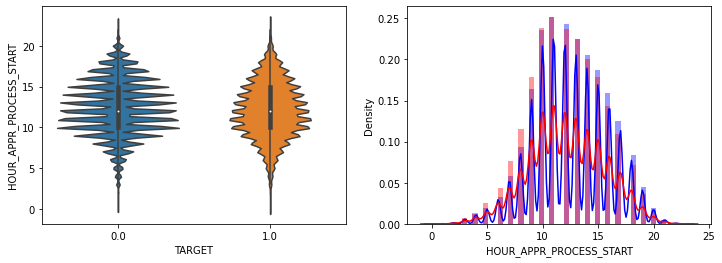

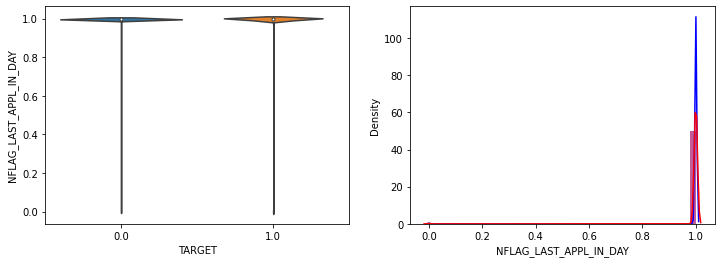

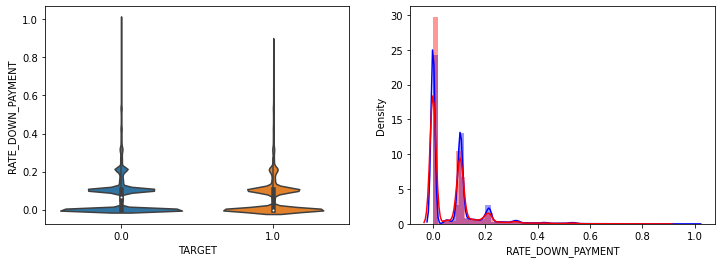

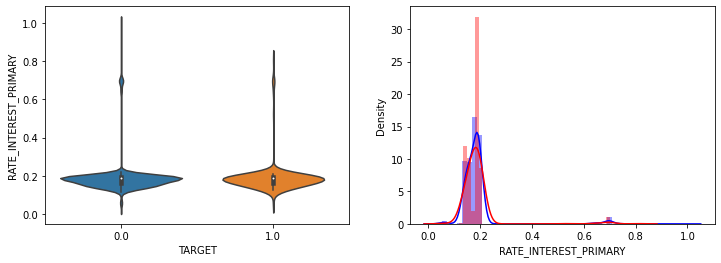

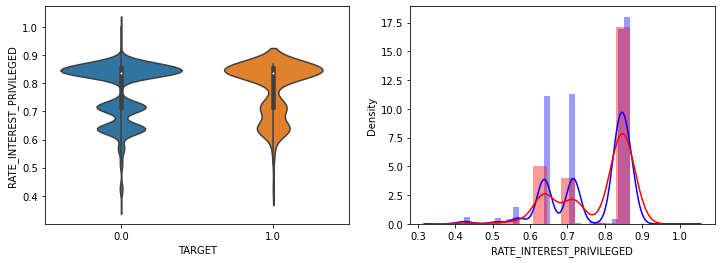

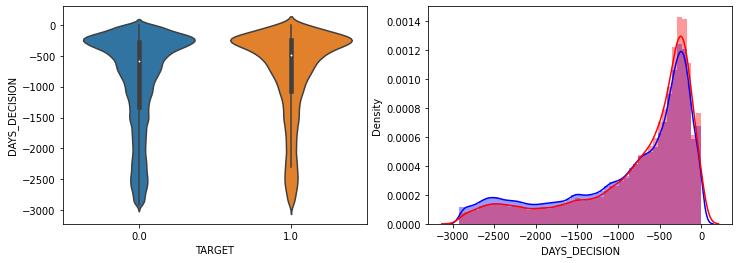

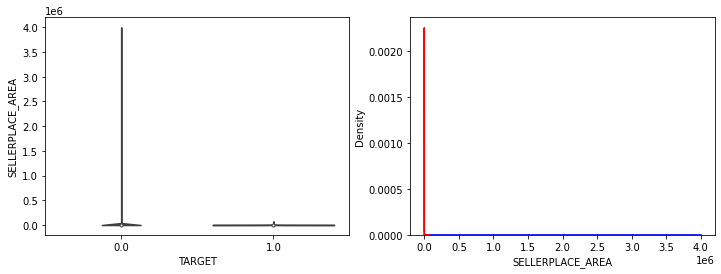

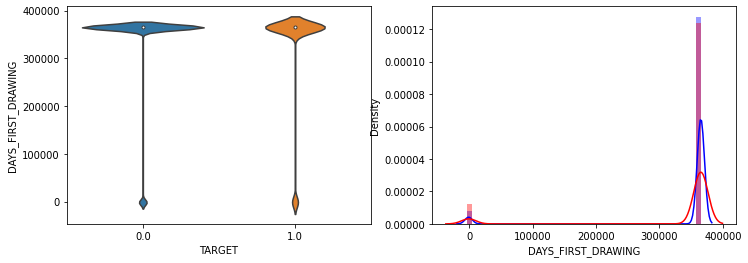

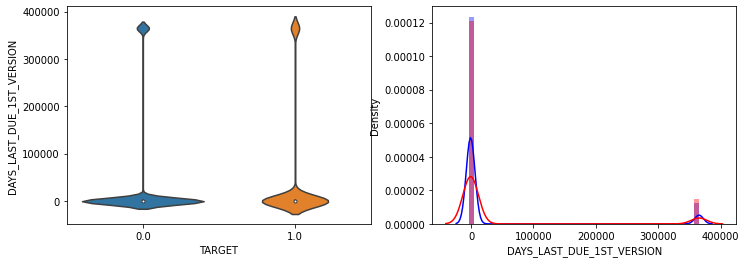

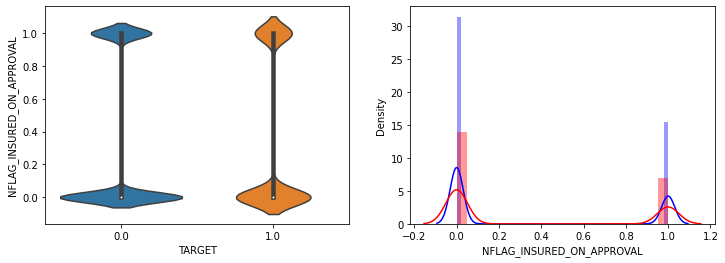

In [19]:
show_hist_by_target(app_prev, num_columns)

- AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT은 TARGET=1인 경우에 소액 비율이 약간 높음(큰 차이는 아님)
- RATE_DOWN_PAYMENT는 큰 차이 없음
- RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED는 NULL값이 매우 많아서 판단 어려움
- DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음
- DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE_, DAYS_TERMINATION은 365243값이 매우 많음

#### category 피처들의 Histogram을 TARGET 유형에 따라 비교

In [20]:
object_columns = app_prev.dtypes[app_prev.dtypes=='object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [21]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col='TARGET', data=df, kind='count')
        chart.set_xticklabels(rotation=65)

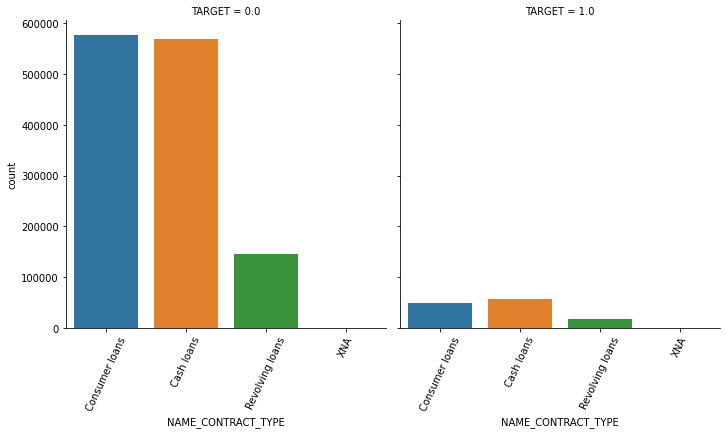

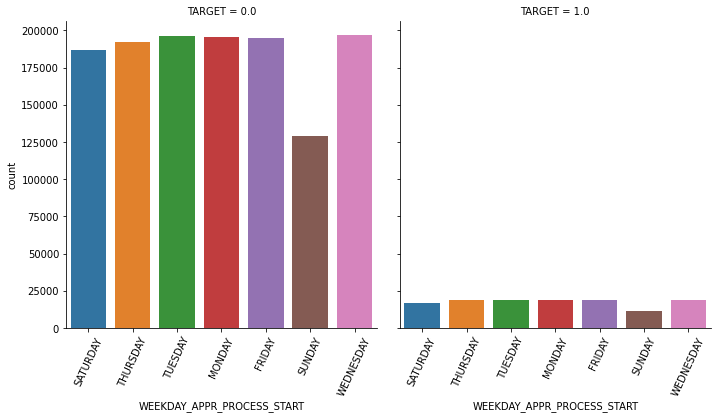

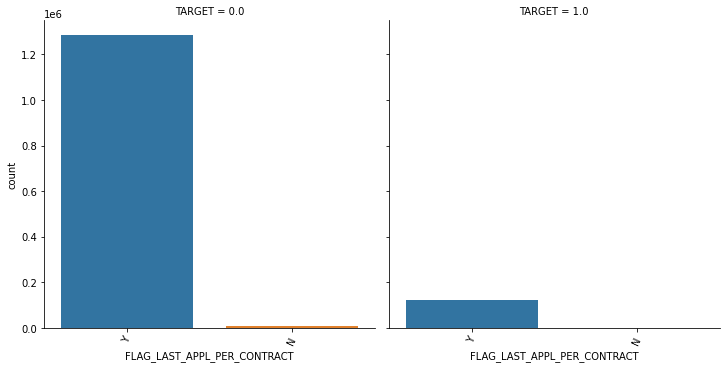

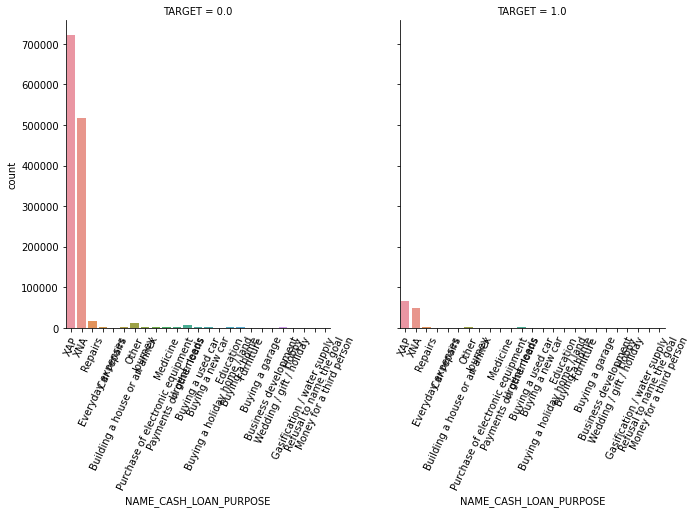

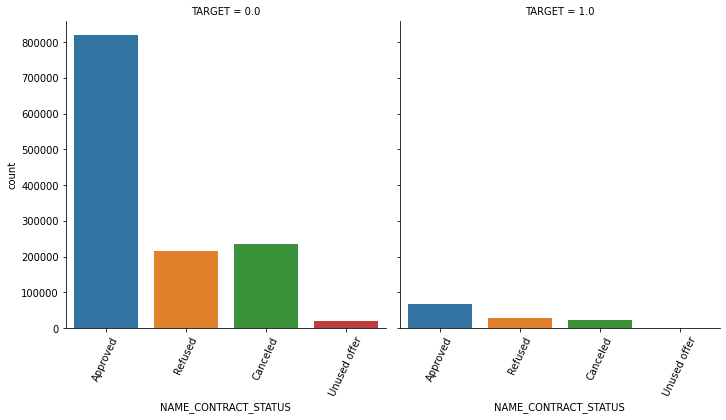

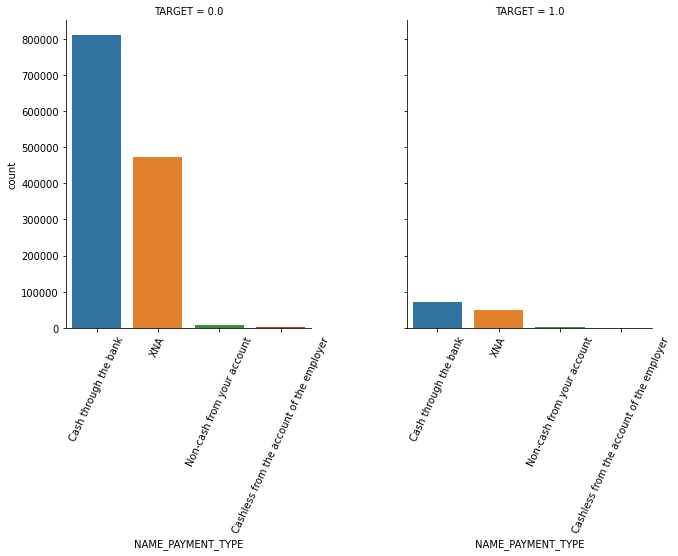

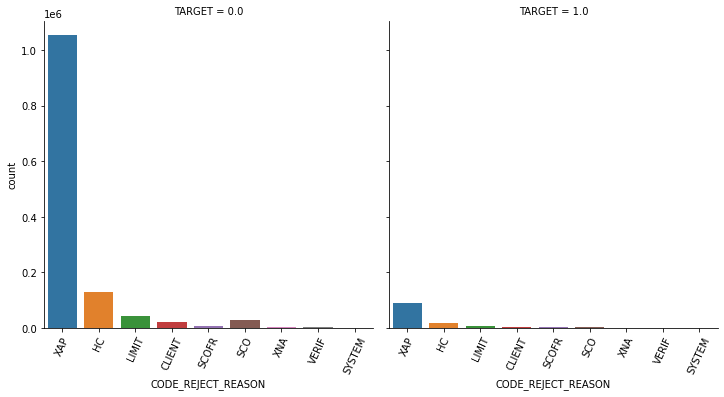

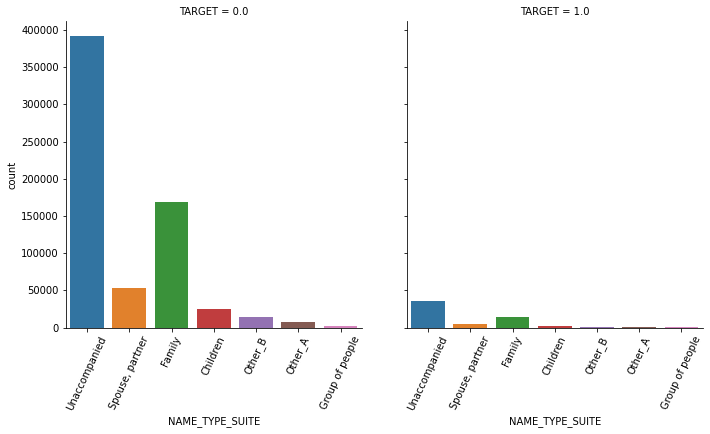

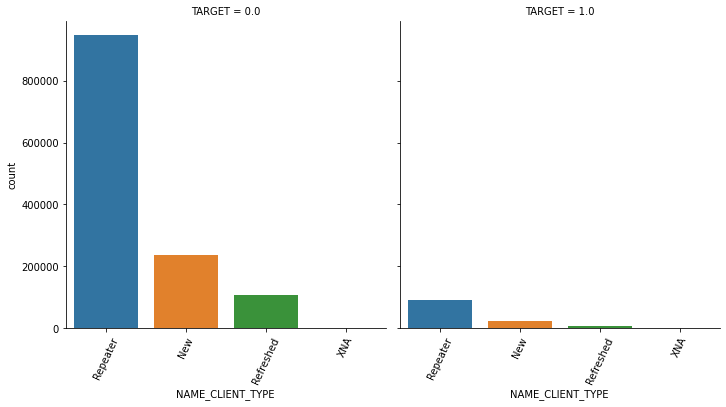

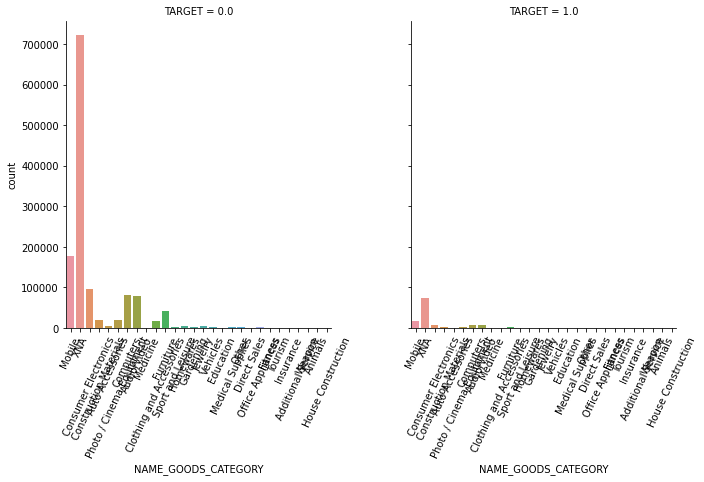

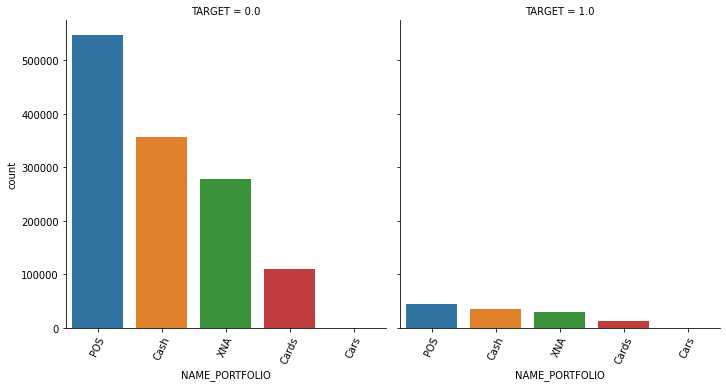

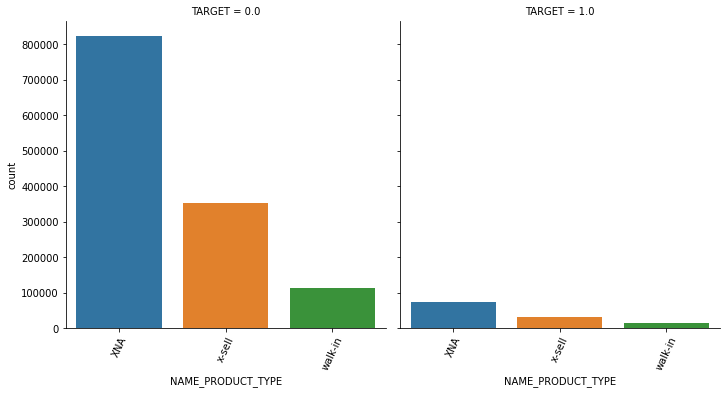

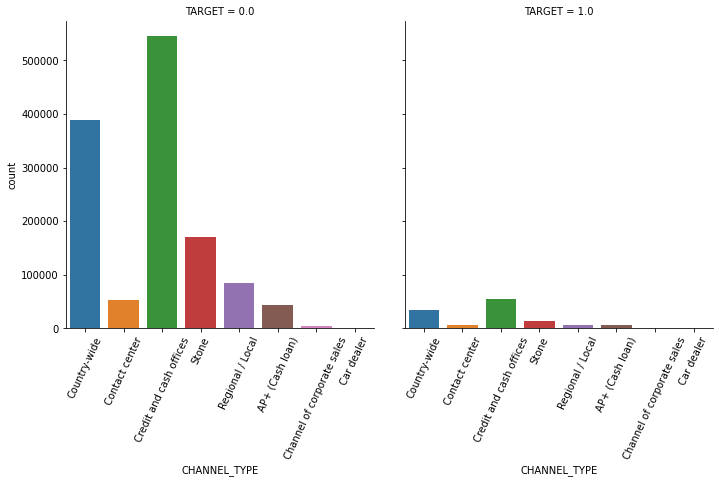

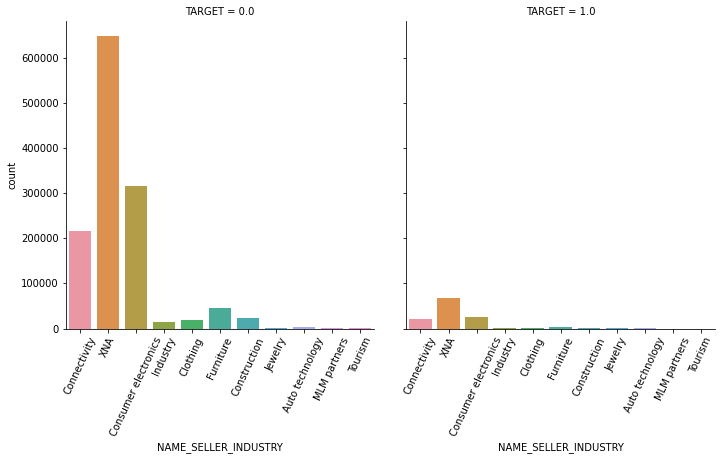

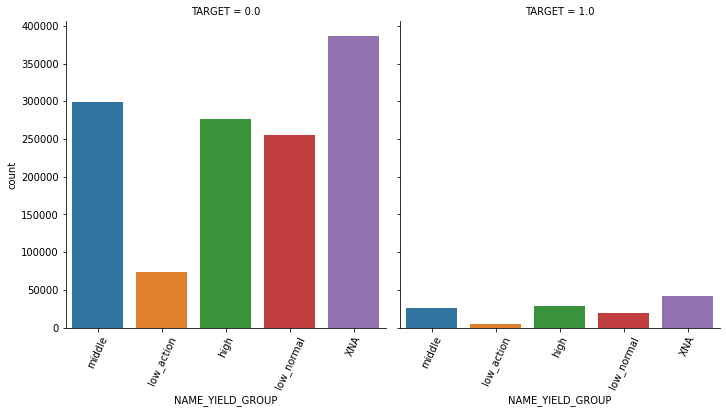

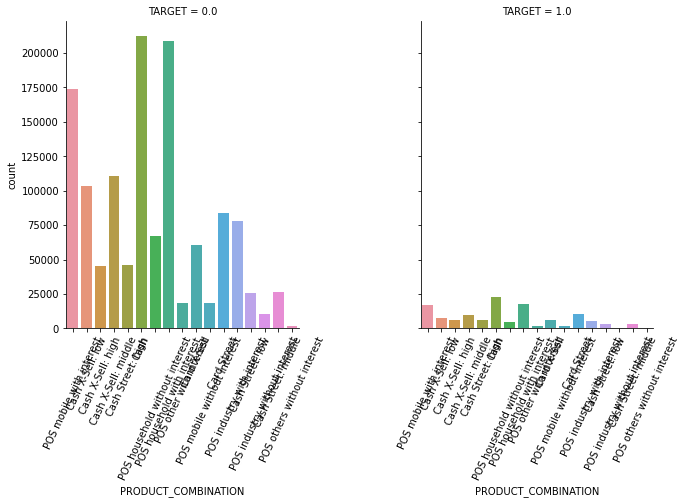

In [22]:
show_category_by_target(app_prev, object_columns)

- NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
- NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일 때 상대적으로 TARGET=0대비 Refused의 비율이 높음
- NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일 때 상대적으로 TARGET=0대비 XNA의 비율이 약간 높음

### PREV 데이터세트 Feature Engineering 수행

#### SQL 대비 Pandas groupby 사용 로직 

#### SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [23]:
# SELECT SK_ID_CURR, COUNT(*), AVG(AMT_CREDIT), MAX(AMT_CREDIT), MIN(AMT_CREDIT) FROM PREVIOUS GROUP BY SK_ID_CURR;

#### pandas groupby 단일 aggregation 함수 사용
- groupby SK_ID_CURR
- SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [24]:
prev_group = prev.groupby('SK_ID_CURR')

In [25]:
prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean()
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].min()

prev_agg.head(10)


CNT     AVG_CREDIT  MAX_CREDIT
SK_ID_CURR                                
100001        1   23787.000000     23787.0
100002        1  179055.000000    179055.0
100003        3  484191.000000     68053.5
100004        1   20106.000000     20106.0
100005        2   20076.750000         0.0
100006        9  291695.500000         0.0
100007        6  166638.750000     14616.0
100008        5  162767.700000         0.0
100009        7   70137.642857     38574.0
100010        1  260811.000000    260811.0

#### groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

In [26]:
prev_group = prev.groupby('SK_ID_CURR')

prev_agg1 = prev_group['AMT_CREDIT'].agg(['min', 'max', 'mean'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['min', 'max', 'mean'])

prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head()

min_x      max_x     mean_x     min_y      max_y     mean_y
SK_ID_CURR                                                                
100001       23787.0    23787.0   23787.00  3951.000   3951.000   3951.000
100002      179055.0   179055.0  179055.00  9251.775   9251.775   9251.775
100003       68053.5  1035882.0  484191.00  6737.310  98356.995  56553.990
100004       20106.0    20106.0   20106.00  5357.250   5357.250   5357.250
100005           0.0    40153.5   20076.75  4813.200   4813.200   4813.200

#### agg()에 dictionary를 이용하여 groupby 적용

In [27]:
agg_dict = {
    'SK_ID_CURR' : ['count'],
    'AMT_CREDIT' : ['mean', 'max', 'sum'],
    'AMT_ANNUITY' : ['mean', 'max', 'sum'],
    'AMT_APPLICATION' : ['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT' : ['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE' : ['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

SK_ID_CURR AMT_CREDIT                       AMT_ANNUITY             \
                count       mean        max        sum        mean        max   
SK_ID_CURR                                                                      
100001              1   23787.00    23787.0    23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0   179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0  1452573.0   56553.990  98356.995   
100004              1   20106.00    20106.0    20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5    40153.5    4813.200   4813.200   

                       AMT_APPLICATION                      AMT_DOWN_PAYMENT  \
                   sum            mean       max        sum             mean   
SK_ID_CURR                                                                     
100001        3951.000        24835.50   24835.5    24835.5           2520.0   
100002        9251.775       179055.00  179055.0   179055.0              0.0   
100003      169661.970       435436.50  900000.0  1306309.5           3442.5   
100004        5357.250        24282.00   24282.0    24282.0           4860.0   
100005        4813.200        22308.75   44617.5    44617.5           4464.0   

                           AMT_GOODS_PRICE                       
               max     sum            mean       max        sum  
SK_ID_CURR                                                       
100001      2520.0  2520.0         24835.5   24835.5    24835.5  
100002         0.0     0.0        179055.0  179055.0   179055.0  
100003      6885.0  6885.0        435436.5  900000.0  1306309.5  
100004      4860.0  4860.0         24282.0   24282.0    24282.0  
100005      4464.0  4464.0         44617.5   44617.5    44617.5

#### groupby agg로 만들어진 Multi index column 변경
- MultiIndex로 되어 있는 컬럼명 확인
- MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경

In [28]:
prev_amt_agg.columns

MultiIndex([(      'SK_ID_CURR', 'count'),
            (      'AMT_CREDIT',  'mean'),
            (      'AMT_CREDIT',   'max'),
            (      'AMT_CREDIT',   'sum'),
            (     'AMT_ANNUITY',  'mean'),
            (     'AMT_ANNUITY',   'max'),
            (     'AMT_ANNUITY',   'sum'),
            ( 'AMT_APPLICATION',  'mean'),
            ( 'AMT_APPLICATION',   'max'),
            ( 'AMT_APPLICATION',   'sum'),
            ('AMT_DOWN_PAYMENT',  'mean'),
            ('AMT_DOWN_PAYMENT',   'max'),
            ('AMT_DOWN_PAYMENT',   'sum'),
            ( 'AMT_GOODS_PRICE',  'mean'),
            ( 'AMT_GOODS_PRICE',   'max'),
            ( 'AMT_GOODS_PRICE',   'sum')],
           )

In [29]:
prev_amt_agg.head()

SK_ID_CURR AMT_CREDIT                       AMT_ANNUITY             \
                count       mean        max        sum        mean        max   
SK_ID_CURR                                                                      
100001              1   23787.00    23787.0    23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0   179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0  1452573.0   56553.990  98356.995   
100004              1   20106.00    20106.0    20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5    40153.5    4813.200   4813.200   

                       AMT_APPLICATION                      AMT_DOWN_PAYMENT  \
                   sum            mean       max        sum             mean   
SK_ID_CURR                                                                     
100001        3951.000        24835.50   24835.5    24835.5           2520.0   
100002        9251.775       179055.00  179055.0   179055.0              0.0   
100003      169661.970       435436.50  900000.0  1306309.5           3442.5   
100004        5357.250        24282.00   24282.0    24282.0           4860.0   
100005        4813.200        22308.75   44617.5    44617.5           4464.0   

                           AMT_GOODS_PRICE                       
               max     sum            mean       max        sum  
SK_ID_CURR                                                       
100001      2520.0  2520.0         24835.5   24835.5    24835.5  
100002         0.0     0.0        179055.0  179055.0   179055.0  
100003      6885.0  6885.0        435436.5  900000.0  1306309.5  
100004      4860.0  4860.0         24282.0   24282.0    24282.0  
100005      4464.0  4464.0         44617.5   44617.5    44617.5

#### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성

In [30]:
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_APPLICATION']
prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY'] / prev['AMT_APPLICATION']
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

#### DAYS_XXX 피처의 365243을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [31]:
prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

In [32]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

#### 기존 이자율 관련 컬럼 NULL값이 많기 때문에 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산

In [33]:
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT'] 
prev['PREV_INTERESTS_RATE'] = (all_pay / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

In [34]:
prev.iloc[:, -7:]

PREV_CREDIT_DIFF  PREV_GOODS_DIFF  PREV_CREDIT_APPL_RATIO  \
0                     0.0              0.0                1.000000   
1                -72171.0              0.0                1.118800   
2                -23944.5              0.0                1.212840   
3                -20790.0              0.0                1.046200   
4                -66555.0              0.0                1.197200   
...                   ...              ...                     ...   
1670209          -44104.5              0.0                1.165003   
1670210           23458.5              0.0                0.732667   
1670211            2713.5              0.0                0.974215   
1670212          -11880.0              0.0                1.066000   
1670213               0.0              0.0                1.000000   

         PREV_ANNUITY_APPL_RATIO  PREV_GOODS_APPL_RATIO  \
0                       0.100929                    1.0   
1                       0.041463                    1.0   
2                       0.133873                    1.0   
3                       0.104536                    1.0   
4                       0.094591                    1.0   
...                          ...                    ...   
1670209                 0.055011                    1.0   
1670210                 0.075465                    1.0   
1670211                 0.109475                    1.0   
1670212                 0.104564                    1.0   
1670213                 0.045642                    1.0   

         PREV_DAYS_LAST_DUE_DIFF  PREV_INTERESTS_RATE  
0                          342.0             0.017596  
1                            NaN             0.009282  
2                            NaN             0.027047  
3                           30.0             0.016587  
4                            NaN             0.037343  
...                          ...                  ...  
1670209                    720.0             0.013887  
1670210                     30.0             0.019667  
1670211                      0.0             0.012373  
1670212                      0.0             0.014757  
1670213                    690.0             0.024809  

[1670214 rows x 7 columns]

#### 기존 대출 금액, 대출 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행

In [35]:
agg_dict = {
    # 기존 컬럼
    'SK_ID_CURR' : ['count'],
    'AMT_CREDIT' : ['mean', 'max', 'sum'],
    'AMT_ANNUITY' : ['mean', 'max', 'sum'],
    'AMT_APPLICATION' : ['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT' : ['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE' : ['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT' : ['min', 'max', 'mean'],
    'DAYS_DECISION' : ['min', 'max', 'mean'],
    'CNT_PAYMENT' : ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF' : ['mean', 'max', 'sum'],
    'PREV_CREDIT_APPL_RATIO' : ['mean', 'max'],
    'PREV_GOODS_DIFF' : ['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO' : ['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF' : ['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE' : ['mean', 'max']
}

In [36]:
prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

In [37]:
prev_amt_agg.head()

PREV_SK_ID_CURR_COUNT  PREV_AMT_CREDIT_MEAN  PREV_AMT_CREDIT_MAX  \
SK_ID_CURR                                                                     
100001                          1              23787.00              23787.0   
100002                          1             179055.00             179055.0   
100003                          3             484191.00            1035882.0   
100004                          1              20106.00              20106.0   
100005                          2              20076.75              40153.5   

            PREV_AMT_CREDIT_SUM  PREV_AMT_ANNUITY_MEAN  PREV_AMT_ANNUITY_MAX  \
SK_ID_CURR                                                                     
100001                  23787.0               3951.000              3951.000   
100002                 179055.0               9251.775              9251.775   
100003                1452573.0              56553.990             98356.995   
100004                  20106.0               5357.250              5357.250   
100005                  40153.5               4813.200              4813.200   

            PREV_AMT_ANNUITY_SUM  PREV_AMT_APPLICATION_MEAN  \
SK_ID_CURR                                                    
100001                  3951.000                   24835.50   
100002                  9251.775                  179055.00   
100003                169661.970                  435436.50   
100004                  5357.250                   24282.00   
100005                  4813.200                   22308.75   

            PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_SUM  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                      900000.0                 1306309.5   
100004                       24282.0                   24282.0   
100005                       44617.5                   44617.5   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                          
100001                          2520.0                     2520.0   
100002                             0.0                        0.0   
100003                          3442.5                     6885.0   
100004                          4860.0                     4860.0   
100005                          4464.0                     4464.0   

            PREV_AMT_DOWN_PAYMENT_SUM  PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                                                         
100001                         2520.0                    24835.5   
100002                            0.0                   179055.0   
100003                         6885.0                   435436.5   
100004                         4860.0                    24282.0   
100005                         4464.0                    44617.5   

            PREV_AMT_GOODS_PRICE_MAX  PREV_AMT_GOODS_PRICE_SUM  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                      900000.0                 1306309.5   
100004                       24282.0                   24282.0   
100005                       44617.5                   44617.5   

            PREV_RATE_DOWN_PAYMENT_MIN  PREV_RATE_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                           
100001                        0.104326                    0.104326   
100002                        0.000000                    0.000000   
100003                        0.000000                    0.100061   
100004                        0.212008                    0.212008   
100005                        0.108964                    0.108964   

            PREV_RATE_DOWN_PAYMENT_MEAN  PREV_DAYS_DECISION_MIN  \
SK_

In [38]:
prev_amt_agg.shape

(338857, 39)

#### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused일 경우의 건수 및 과거 대출건 대비 비율

#### Groupby기준 컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행

In [39]:
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

SQL Group by Case when과 pandas의 차이

In [40]:
# SK_ID_CURR레벨로 groupby된 count와 name_contract_status가 Refused일 때의 count
'''
select sk_id_curr, cnt_refused/cnt
from
(
    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused
    from previous group by sk_id_curr
)
'''

##### pandas는 원 DataFrame에 groupby 적용된 DataFrame과 세부기준으로 filtering된 DataFrame에 groupby 적용된 DataFrame을 조인하여 생성

- NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용
- groupby 완료 후 기존 prev_amt_agg와 조인
- 효율적인 오류 방지를 위해 groupby시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경

In [42]:
cond_refused = (prev['NAME_CONTRACT_STATUS'] == 'Refused')
prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape

((290678, 44), (1670214, 44))

In [45]:
prev_refused_agg = prev_refused.groupby('SK_ID_CURR')['SK_ID_CURR'].count()
prev_refused_agg.shape, prev_amt_agg.shape

((118277,), (338857, 39))

In [49]:
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')

TypeError: reset_index() got an unexpected keyword argument 'name'